In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.SummaryActionScalars import SummaryActionScalars

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True # Enable LaTeX rendering

2024-05-31 16:01:49.130895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load data
log_dir = 'experiments/tensorboard_logs/Boxing'

env = os.path.basename(os.path.dirname(log_dir))

# choose temperature parameter
temperature = 0.1

runs = os.listdir(log_dir)
runs = [run for run in runs if run !='.DS_Store']

all_summary_scalars = list()
all_action_results  = list()
all_global_results  = list()

# filter the runs by temperature
filtered_runs = list()
alphas = list()
print('runs: \n')
for run in runs:
    print(run)
    env, _, temp, _, alpha, _, seed = run.split('_')
    if alpha not in alphas:
        alphas.append(alpha)
    if float(temp) == temperature:
        filtered_runs.append(run)

for run in filtered_runs:
    all_summary_scalars.append(SummaryActionScalars(log_dir, run))
    
    all_action_results.append(all_summary_scalars[-1].generate_summary_action_scalars())
    all_global_results.append(all_summary_scalars[-1].generate_summary_global_scalars())

del all_summary_scalars

runs: 

Boxing_temp_0.1_alpha_5.0_seed_20
Boxing_temp_0.1_alpha_5.0_seed_10
Boxing_temp_0.1_alpha_2.0_seed_20
Boxing_temp_0.1_alpha_2.0_seed_10
Boxing_temp_0.1_alpha_1.5_seed_10
Boxing_temp_0.1_alpha_1.5_seed_20
Boxing_temp_0.1_alpha_1.0_seed_30
Boxing_temp_0.1_alpha_1.5_seed_30
Boxing_temp_0.1_alpha_1.0_seed_20
Boxing_temp_0.1_alpha_1.0_seed_10
Boxing_temp_0.1_alpha_2.0_seed_30
Boxing_temp_0.1_alpha_5.0_seed_30


In [6]:
all_global_results[0].keys()

dict_keys(['alpha_2_entropy', 'max_actor_grad', 'max_critic_grad', 'n_episodes', 'p_loss', 'reward', 'sparsity', 'tsallis_entropy', 'v_loss', 'wsn_distance'])

In [7]:
filtered_runs

['Boxing_temp_0.1_alpha_5.0_seed_20',
 'Boxing_temp_0.1_alpha_5.0_seed_10',
 'Boxing_temp_0.1_alpha_2.0_seed_20',
 'Boxing_temp_0.1_alpha_2.0_seed_10',
 'Boxing_temp_0.1_alpha_1.5_seed_10',
 'Boxing_temp_0.1_alpha_1.5_seed_20',
 'Boxing_temp_0.1_alpha_1.0_seed_30',
 'Boxing_temp_0.1_alpha_1.5_seed_30',
 'Boxing_temp_0.1_alpha_1.0_seed_20',
 'Boxing_temp_0.1_alpha_1.0_seed_10',
 'Boxing_temp_0.1_alpha_2.0_seed_30',
 'Boxing_temp_0.1_alpha_5.0_seed_30']

# Action Metrics

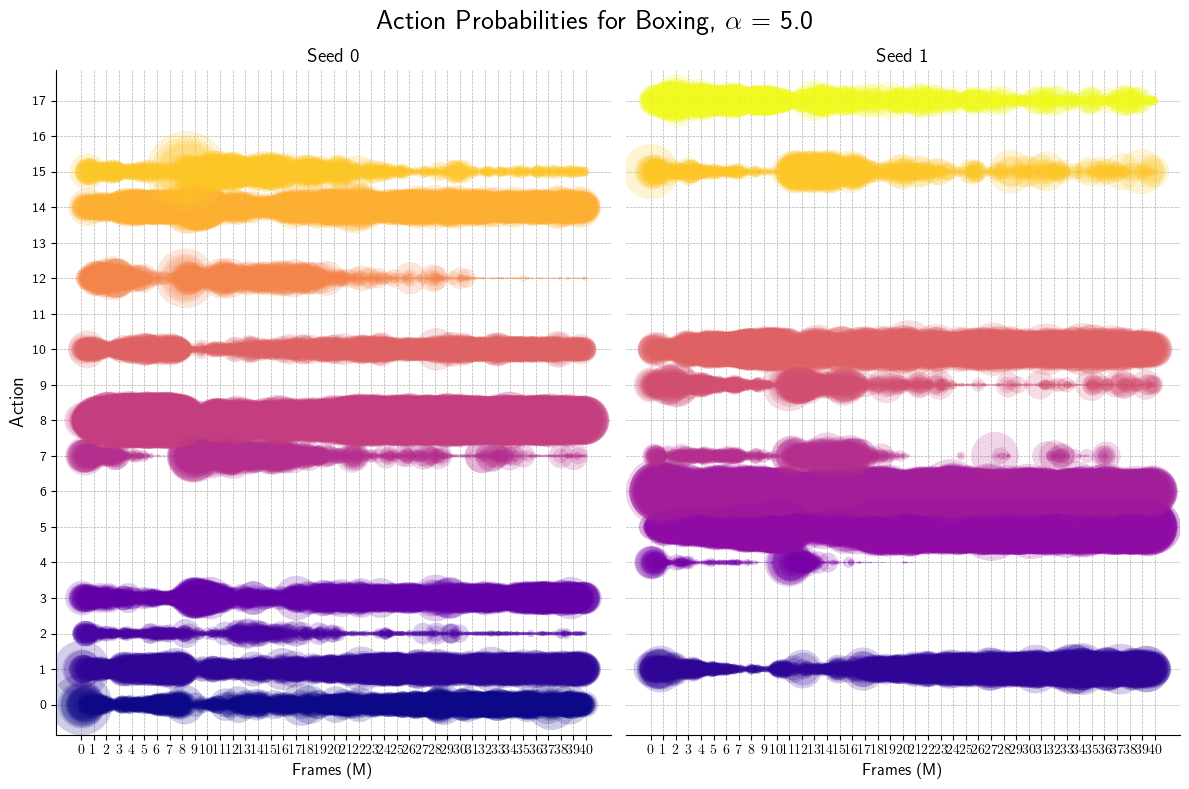

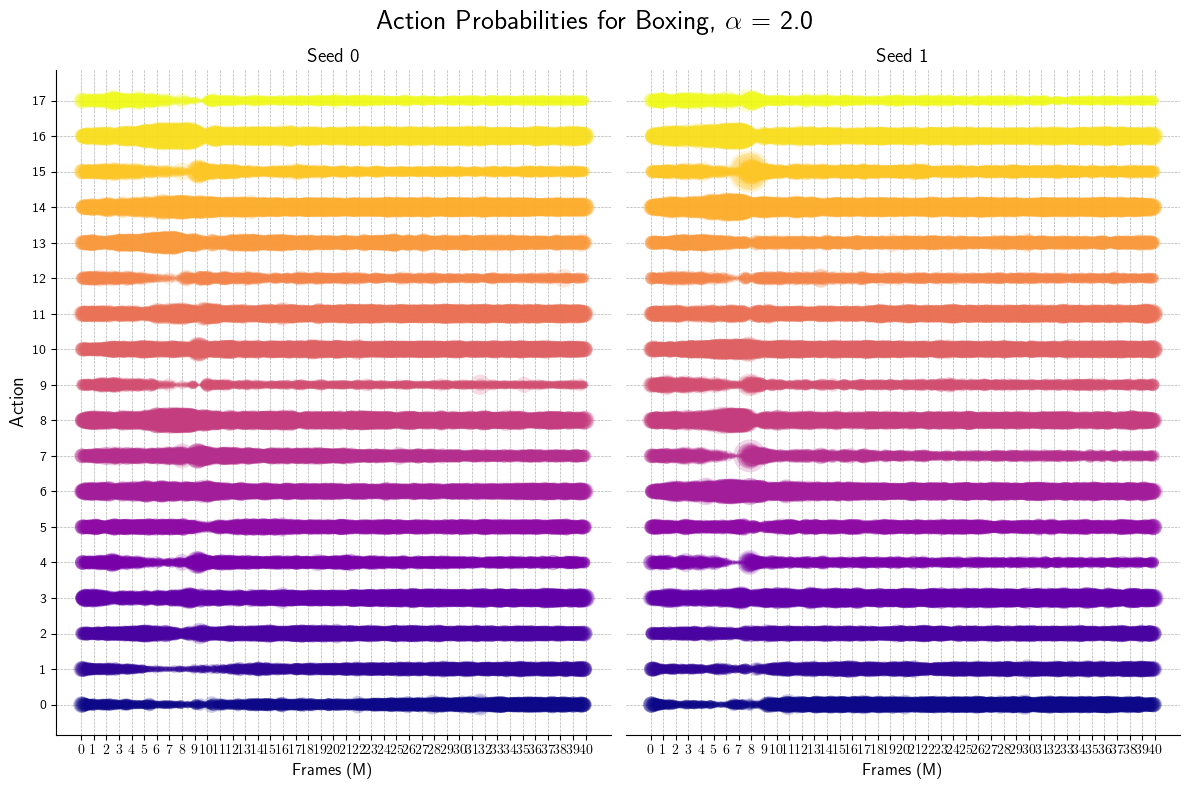

KeyboardInterrupt: 

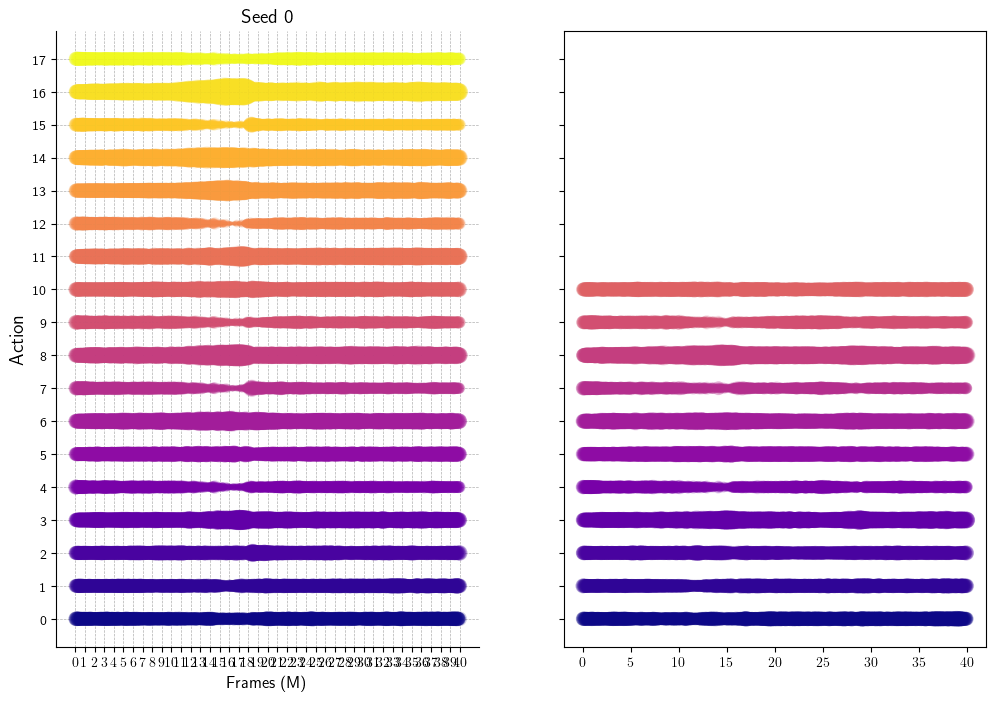

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# function that creates the plot for a given metric per action (action_probs) dictionary
def create_subplot(ax, action_probs, title_suffix, alpha_value=0.2, include_ylabel=True):
    sorted_actions = sorted(action_probs.keys())
    action_to_y = {action: idx for idx, action in enumerate(sorted_actions)}
    cmap = plt.cm.plasma

    max_step = 0
    for action, color in zip(sorted_actions, cmap(np.linspace(0, 1, len(sorted_actions)))):
        df = action_probs[action]
        bin_size = 2 #50
        num_bins = len(df) // bin_size
        binned_df = pd.DataFrame({
            'step': [(df.iloc[i*bin_size:(i+1)*bin_size]['step'].mean() * 16) / 1e6 for i in range(num_bins)],
            'value': [df.iloc[i*bin_size:(i+1)*bin_size]['value'].mean() for i in range(num_bins)]
        })
        max_step = max(max_step, binned_df['step'].max())

        y = action_to_y[action] * np.ones(len(binned_df))
        x = binned_df['step']
        sizes = (binned_df['value'] ** 1.5) * 8000

        face_colors = np.full((len(x), 4), [*color[:3], alpha_value])
        ax.scatter(x, y, s=sizes, facecolors=face_colors, edgecolors=(1, 1, 1, 0), zorder=10)

    ax.set_xticks(np.arange(0, max_step + 1, 1))
    ax.set_yticks(list(action_to_y.values()))
    ax.set_yticklabels([f'{action}' for action in sorted_actions])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Frames (M)', fontsize=12)
    if include_ylabel:
        ax.set_ylabel('Action', fontsize=14)
    else:
        ax.spines[['left']].set_visible(False)
        ax.yaxis.set_ticks_position('none') 
        
    ax.set_title(f'{title_suffix}', fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=-10)

for i, alpha in enumerate(alphas):
    # Prepare figure with specified size
    fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    
    create_subplot(axs[0], all_action_results[2*i]['action_probs'], "Seed 0")
    create_subplot(axs[1], all_action_results[2*i+1]['action_probs'], "Seed 1", include_ylabel=False)

    plt.suptitle(r'Action Probabilities for Boxing, $\alpha$ = ' + str(alpha), fontsize=20)
    plt.tight_layout()
    plt.show()

# Global Metrics

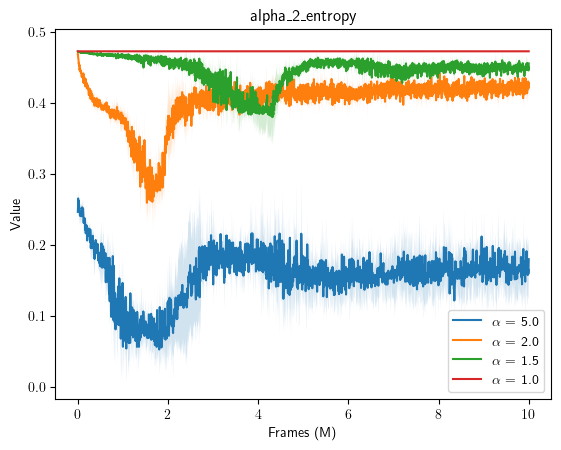

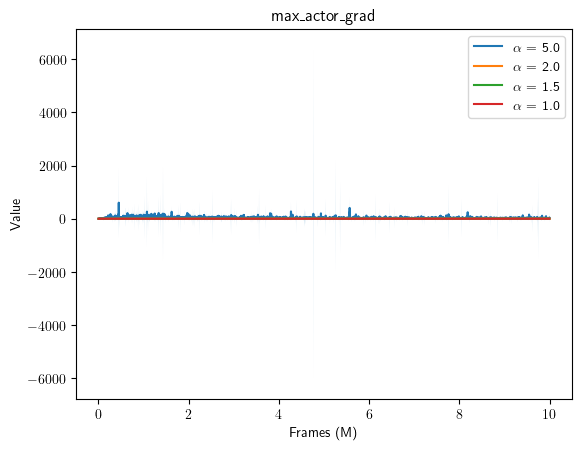

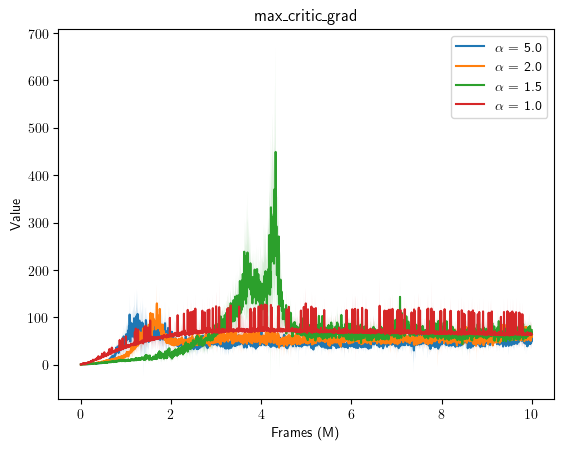

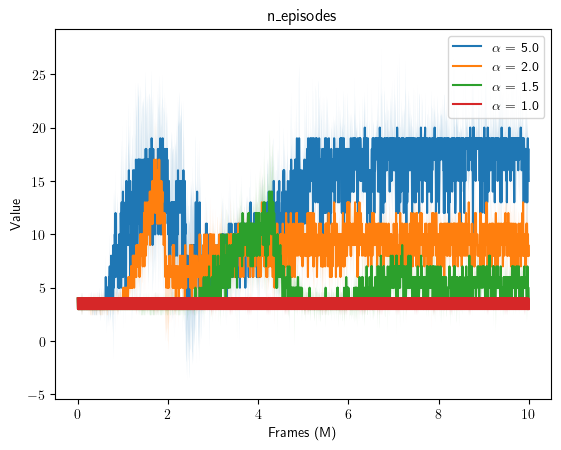

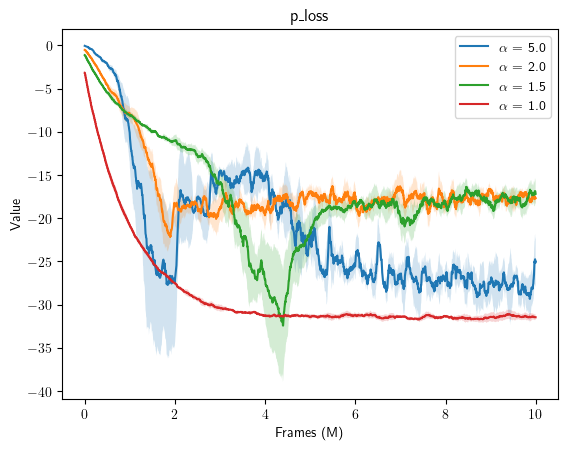

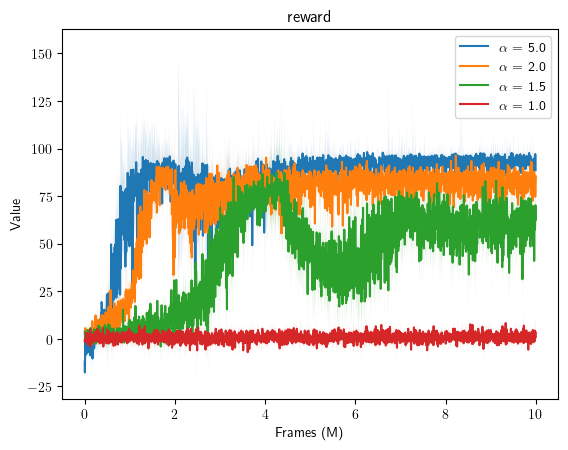

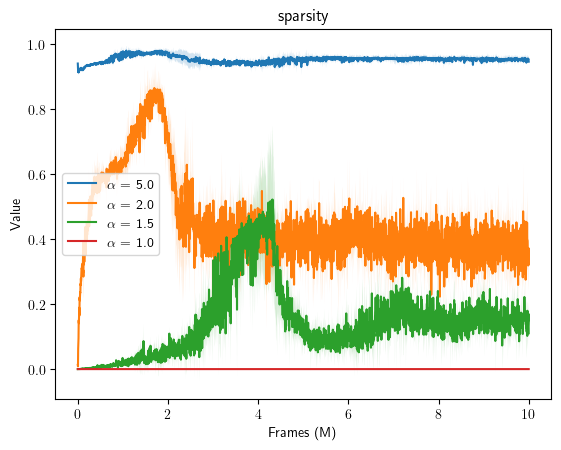

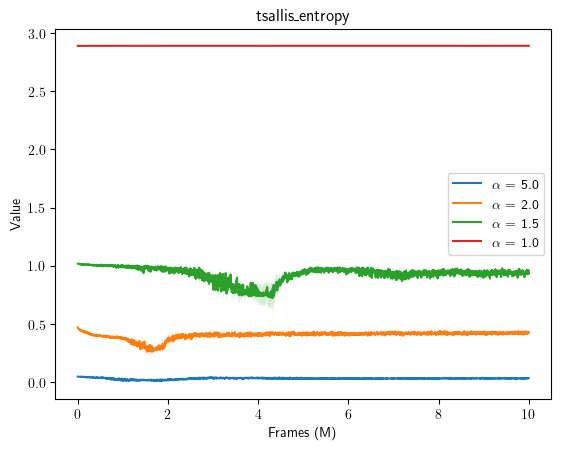

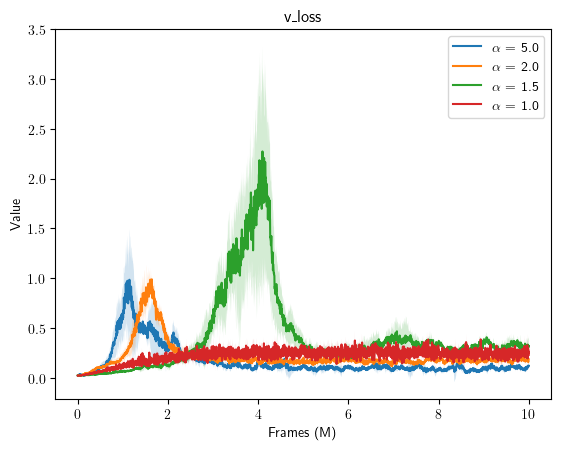

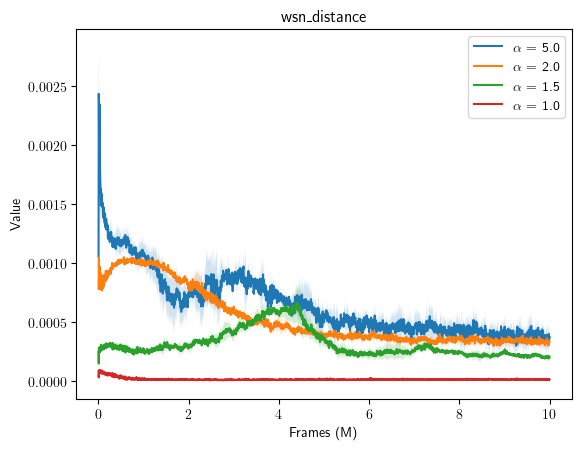

In [9]:
for scalar in all_global_results[0].keys():
    data_by_alpha = {}
    for i, global_results in enumerate(all_global_results):
        _, _, temp, _, alpha, _, seed = runs[i].split('_')
        if alpha not in data_by_alpha:
            data_by_alpha[alpha] = []

        if float(temp) == temperature:
            global_results[scalar]['step_transformed'] = (global_results[scalar]['step'] * 4) / 1e6
            data_by_alpha[alpha].append(global_results[scalar])

    plt.figure()
    plt.title(scalar)
    
    for alpha, dfs in data_by_alpha.items():
        # ensuring all DataFrames have the same number of rows. Some experiments ended a step before
        min_length = min(df.shape[0] for df in dfs)
        trimmed_dfs = [df.iloc[:min_length] for df in dfs]
        concatenated_df = pd.concat(trimmed_dfs, ignore_index=True)
        
        # compute median and std deviation by transformed 'step'
        median_vals = concatenated_df.groupby('step_transformed').median()
        std_dev_vals = concatenated_df.groupby('step_transformed').std()

        # plotting
        steps_transformed = median_vals.index
        plt.plot(steps_transformed, median_vals['value'], label=r'$\alpha$ = ' + str(alpha))
        plt.fill_between(steps_transformed, median_vals['value'] - std_dev_vals['value'], median_vals['value'] + std_dev_vals['value'], alpha=0.2)

    plt.legend()
    plt.xlabel('Frames (M)')
    plt.ylabel('Value')
    plt.show()

# Reward & Sparsity Plots

In [11]:
scalar='Reward'

window_size = 10

scaling_factor=1 #boxing
#scaling_factor=2 #alien
#scaling_factor=3 #seaquest
#scaling_factor=5 #breakout

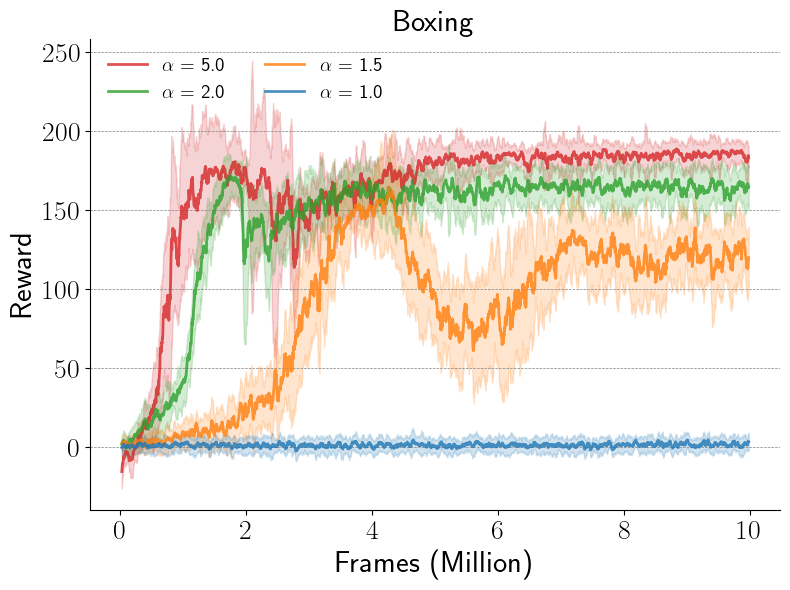

In [12]:
plt.figure(figsize=(8, 6))

data_by_alpha = {}
for i, global_results in enumerate(all_global_results):
    _, _, temp, _, alpha, _, seed = runs[i].split('_')
    if alpha not in data_by_alpha:
        data_by_alpha[alpha] = []

    if float(temp) == temperature:
        global_results[scalar.lower()]['step_transformed'] = (global_results[scalar.lower()]['step']) * 4 / 1e6
        data_by_alpha[alpha].append(global_results[scalar.lower()]*scaling_factor)

# Create a normalized color scale based on alpha values
alphas = sorted(data_by_alpha.keys())
color_map = plt.cm.coolwarm
norm = plt.Normalize(min(alphas), max(alphas))

colors = {'5.0': 'C3', '2.0': 'C2', '1.5': 'C1', '1.0': 'C0'}

for alpha, dfs in data_by_alpha.items():
    min_length = min(df.shape[0] for df in dfs)
    trimmed_dfs = [df.iloc[:min_length] for df in dfs]
    concatenated_df = pd.concat(trimmed_dfs, ignore_index=True)
    
    median_vals = concatenated_df.groupby('step_transformed').median()
    std_dev_vals = concatenated_df.groupby('step_transformed').std()

    median_vals_smoothed = median_vals['value'].rolling(window=window_size, center=True).mean()
    std_dev_vals_smoothed = std_dev_vals['value'].rolling(window=window_size, center=True).mean()

    steps_transformed = median_vals.index
    color = colors[alpha]
    plt.plot(steps_transformed/scaling_factor, median_vals_smoothed, label=f'$\\alpha$ = {alpha}', linewidth=2, alpha=0.8, color=color)
    plt.fill_between(steps_transformed/scaling_factor, 
                     median_vals_smoothed - std_dev_vals_smoothed, 
                     median_vals_smoothed + std_dev_vals_smoothed, color=color, alpha=0.2)

plt.xlabel('Frames (Million)', fontsize=22)
plt.ylabel(scalar, fontsize=22)
plt.title(env, fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.gca().xaxis.grid(False)

if scalar == 'Reward':
    plt.legend(loc='upper left', frameon=False, fontsize=14, ncols=2)

plt.tight_layout()
plt.savefig(f'{env}_{scalar}.pdf')
plt.show()